# Classification Analysis using Several Methods

## Objectives

- Compare several classification methods for predicting heart disease.
- Evaluate the performance of each classifier using metrics like accuracy, F1 score, and AUC.

## Background

This analysis explores various classification methods to predict heart disease presence based on clinical and physiological features, providing insights into model performance and feature importance.

## Datasets Used

Heart Dataset: This dataset consists of clinical measurements (such as blood pressure, cholesterol levels, and heart rate) from 918 patients used to predict the presence of heart disease.

## Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
# set default figure size
sns.set_theme(rc={"figure.figsize":(6, 4)})

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

## Heart Dataset

In [3]:
df = pd.read_csv('heart.csv')
print(df.shape)
df.head()

(918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Let's use only some variables:
- independent variables: `Age`, `Sex`, `ChestPainType`, `RestingBP`, `Cholesterol`, `MaxHR`
- dependent variable: `HeartDisease`

In [4]:
df = df[['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'MaxHR', 'HeartDisease']]
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,MaxHR,HeartDisease
0,40,M,ATA,140,289,172,0
1,49,F,NAP,160,180,156,1
2,37,M,ATA,130,283,98,0
3,48,F,ASY,138,214,108,1
4,54,M,NAP,150,195,122,0


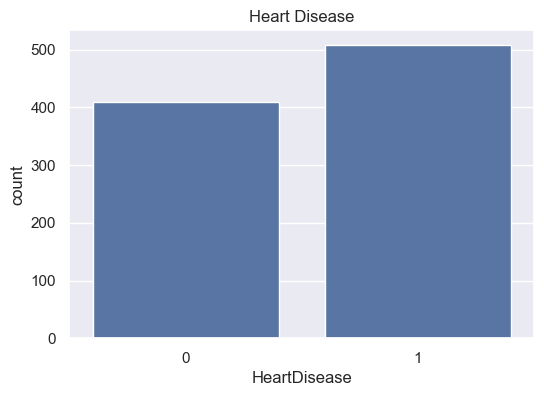

In [5]:
sns.countplot(x=df.HeartDisease).set(title="Heart Disease");

In [6]:
# Counting the NaN values in each column
df.isnull().sum()

Age              0
Sex              0
ChestPainType    0
RestingBP        0
Cholesterol      0
MaxHR            0
HeartDisease     0
dtype: int64

## Descriptive Analysis

In [7]:
print(df.shape)
df.head()

(918, 7)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,MaxHR,HeartDisease
0,40,M,ATA,140,289,172,0
1,49,F,NAP,160,180,156,1
2,37,M,ATA,130,283,98,0
3,48,F,ASY,138,214,108,1
4,54,M,NAP,150,195,122,0


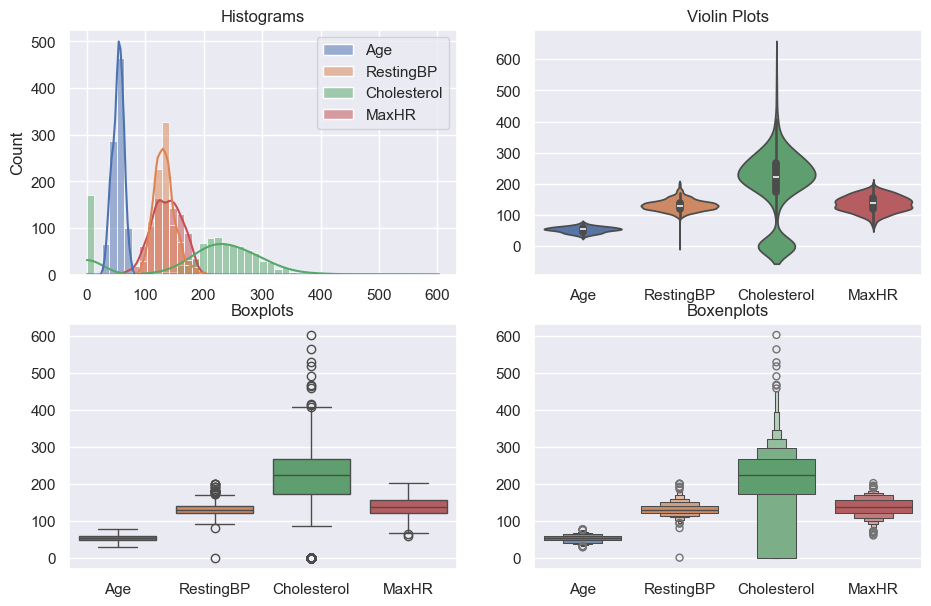

In [8]:
# Numerical features
plt.figure(figsize=(11, 7))

plt.subplot(221)
sns.histplot(
    data=df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']],
    kde=True
).set(title="Histograms")

plt.subplot(222)
sns.violinplot(
    data=df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']]
).set(title="Violin Plots")

plt.subplot(223)
sns.boxplot(
    data=df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']]
).set(title="Boxplots")

plt.subplot(224)
sns.boxenplot(
    data=df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']]
).set(title="Boxenplots");

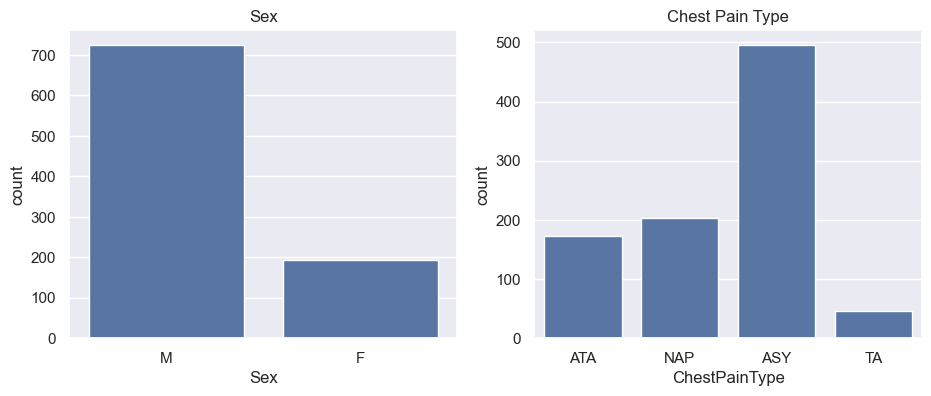

In [9]:
# Analysing categorical variable
plt.figure(figsize=(11, 4))

plt.subplot(121)
sns.countplot(x=df.Sex).set(title="Sex")

plt.subplot(122)
sns.countplot(x=df.ChestPainType).set(title="Chest Pain Type");

## Preparing the data

### Feature Scaling

In [10]:
# Feature Scaling
scaler = preprocessing.StandardScaler()
dfs = pd.DataFrame(
    scaler.fit_transform(df[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']]),
    columns=['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
)
print(dfs.shape)
dfs.head()

(918, 4)


,Age,RestingBP,Cholesterol,MaxHR
0,-1.433140,0.410909,0.825070,1.382928
1,-0.478484,1.491752,-0.171961,0.754157
2,-1.751359,-0.129513,0.770188,-1.525138
3,-0.584556,0.302825,0.139040,-1.132156
4,0.051881,0.951331,-0.034755,-0.581981


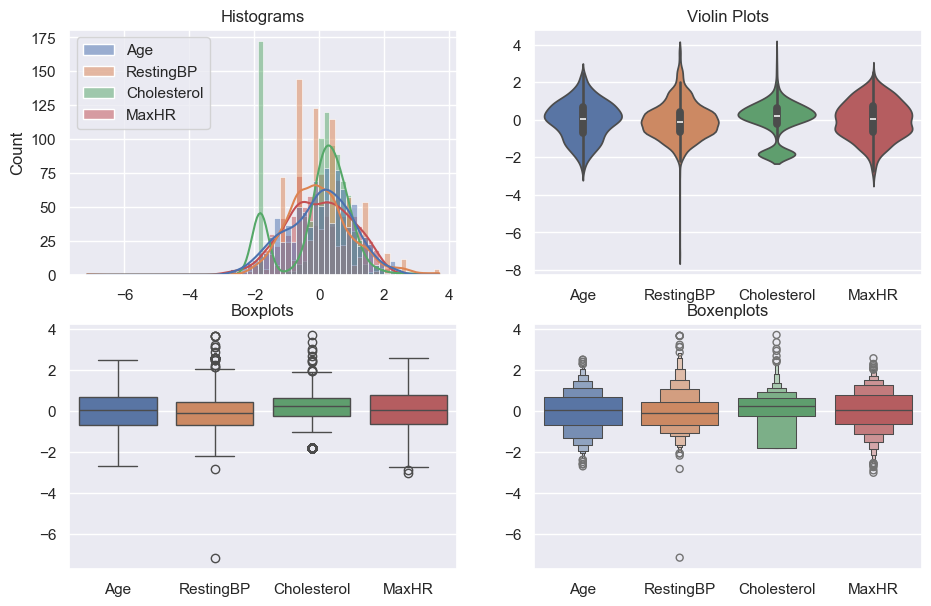

In [11]:
# Numerical features
plt.figure(figsize=(11, 7))

plt.subplot(221)
sns.histplot(
    data=dfs[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']],
    kde=True
).set(title="Histograms")

plt.subplot(222)
sns.violinplot(
    data=dfs[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']]
).set(title="Violin Plots")

plt.subplot(223)
sns.boxplot(
    data=dfs[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']]
).set(title="Boxplots")

plt.subplot(224)
sns.boxenplot(
    data=dfs[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']]
).set(title="Boxenplots");

It looks like there are some outliers. Let's remove some of them.

We have those variables standardized, let's use the z-score method for memoving outliers.

In [12]:
threshold = 3
idx_outl_Age         = dfs.index[np.abs(dfs.Age) >  threshold]
idx_outl_RestingBP   = dfs.index[np.abs(dfs.RestingBP) >  threshold]
idx_outl_Cholesterol = dfs.index[np.abs(dfs.Cholesterol) >  threshold]
idx_outl_MaxHR       = dfs.index[np.abs(dfs.MaxHR) >  threshold]

In [13]:
# Computing the union of all indexes where there are outliers
idx_outl = set(idx_outl_Age) | set(idx_outl_RestingBP) | set(idx_outl_Cholesterol) | set(idx_outl_MaxHR)
idx_outl

{76, 109, 149, 241, 365, 390, 399, 449, 592, 616, 732, 759}

In [14]:
# Removing the cases with any detected outlier
print(f'Original DataFrame: {df.shape} Standardized DataFrame: {dfs.shape}')
df  = df.drop(list(idx_outl))
dfs = dfs.drop(list(idx_outl))
print(f'After removing the outliers...')
print(f'Original DataFrame: {df.shape} Standardized DataFrame: {dfs.shape}')

Original DataFrame: (918, 7) Standardized DataFrame: (918, 4)
After removing the outliers...
Original DataFrame: (906, 7) Standardized DataFrame: (906, 4)


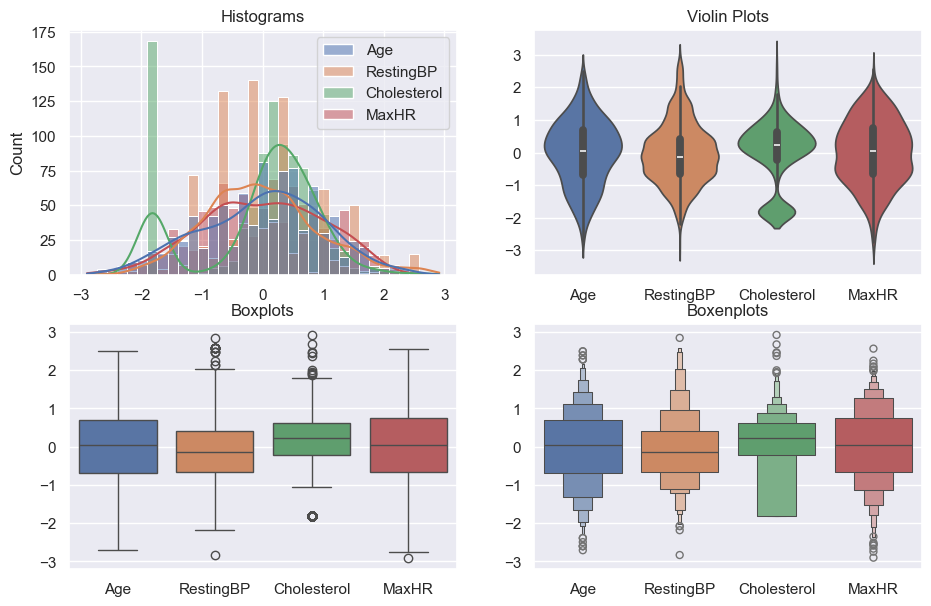

In [15]:
# Numerical features, without outliers
plt.figure(figsize=(11, 7))

plt.subplot(221)
sns.histplot(
    data=dfs[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']], kde=True
).set(title="Histograms")

plt.subplot(222)
sns.violinplot(
    data=dfs[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']]
).set(title="Violin Plots")

plt.subplot(223)
sns.boxplot(
    data=dfs[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']]
).set(title="Boxplots")

plt.subplot(224)
sns.boxenplot(
    data=dfs[['Age', 'RestingBP', 'Cholesterol', 'MaxHR']]
).set(title="Boxenplots");

### One-hot Encoding

One-hot encoding is a representation of categorical variables as binary vectors. Pandas provide a function for it.

In [16]:
df.Sex.value_counts()

Sex
M    716
F    190
Name: count, dtype: int64

In [17]:
Sex_encod = pd.get_dummies(df.Sex, drop_first=True)
Sex_encod.head()

,M
0,True
1,False
2,True
3,False
4,True


In [18]:
df.ChestPainType.value_counts()

ChestPainType
ASY    489
NAP    200
ATA    171
TA      46
Name: count, dtype: int64

In [19]:
ChestPain_encod = pd.get_dummies(df.ChestPainType, drop_first=True)
ChestPain_encod.head()

,ATA,NAP,TA
0,True,False,False
1,False,True,False
2,True,False,False
3,False,False,False
4,False,True,False


We do not need four columns. Notice we got only three.
|  | `ATA` | `NAP` | `TA` |
|---:|:---:|:---:|:---:|
| ASY | 0 | 0 | 0 |
| ATA | 1 | 0 | 0 |
| NAP | 0 | 1 | 0 |
| TA | 0 | 0 | 1 |


In [20]:
# Feature Matrix with standardized or encoded variables
Xs = pd.concat([dfs, Sex_encod, ChestPain_encod], axis=1)
print(Xs.shape)
Xs.head()

(906, 8)


,Age,RestingBP,Cholesterol,MaxHR,M,ATA,NAP,TA
0,-1.433140,0.410909,0.825070,1.382928,True,True,False,False
1,-0.478484,1.491752,-0.171961,0.754157,False,False,True,False
2,-1.751359,-0.129513,0.770188,-1.525138,True,True,False,False
3,-0.584556,0.302825,0.139040,-1.132156,False,False,False,False
4,0.051881,0.951331,-0.034755,-0.581981,True,False,True,False


In [21]:
# Target variable
y = df.HeartDisease

In [22]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=20) 
print(f'Train Set: {Xs_train.shape[0]} cases, \tTest Set: {Xs_test.shape[0]} cases') 

Train Set: 634 cases, 	Test Set: 272 cases


## Computing some models

Let's create a dict `results_classif` with the results of all classifiers:
- the key field will be three letters indicating the classifier name, LRM for Logistic Regression Model, and so on.
- The value fiel will be another dict with useful information about the classifier, for instance:
    - `fpr`: false positive rate (for plotting the ROC curve)
    - `tpr`: true positive rate (for plotting the ROC curve)
    - `auc`: are under the ROC curve
    - `acc`: accuracy
    - `f1`: f1 score

In [23]:
results_classif = {}

Feature scaling is not strictly necessary for logistic regression, but it can be helpful. We will use standardized variables for our logistic model.

In [24]:
# Logistic Regression Model
model = LogisticRegression(C=1e9, random_state=0)
model.fit(X=Xs_train, y=y_train)
pred = model.predict(Xs_test)
prob = model.predict_proba(Xs_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, prob)
auc_roc = auc(fpr, tpr)
acc = accuracy_score(y_true=y_test, y_pred=pred)
f1 = f1_score(y_true=y_test, y_pred=pred)
results_classif['LRM'] = {
    'fpr': fpr,
    'tpr': tpr,
    'auc': auc_roc,
    'acc': acc,
    'f1': f1
}
print(f'Trainning Set - Logistic Regression Model - Accuracy = {model.score(X=Xs_train, y=y_train):.4f}')

Trainning Set - Logistic Regression Model - Accuracy = 0.7855


It is recommended to scale predictor variables in a discriminant analysis. We will use standardized variables for our discriminant models.

In [25]:
# Linear Discriminant Analysis Model
model = LinearDiscriminantAnalysis()
model.fit(X=Xs_train, y=y_train)
pred = model.predict(Xs_test)
prob = model.predict_proba(Xs_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, prob)
auc_roc = auc(fpr, tpr)
acc = accuracy_score(y_true=y_test, y_pred=pred)
f1 = f1_score(y_true=y_test, y_pred=pred)
results_classif['LDA'] = {
    'fpr': fpr,
    'tpr': tpr,
    'auc': auc_roc,
    'acc': acc, 
    'f1': f1
}
print(f'Trainning Set - Linear Discr. Analysis - Accuracy = {model.score(X=Xs_train, y=y_train):.4f}')

Trainning Set - Linear Discr. Analysis - Accuracy = 0.7839


In [26]:
# Quadratic Discriminant Analysis Model
model = QuadraticDiscriminantAnalysis() 
model.fit(X=Xs_train, y=y_train)
pred = model.predict(Xs_test)
prob = model.predict_proba(Xs_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, prob)
auc_roc = auc(fpr, tpr)
acc = accuracy_score(y_true=y_test, y_pred=pred)
f1 = f1_score(y_true=y_test, y_pred=pred)
results_classif['QDA'] = {
    'fpr': fpr, 
    'tpr': tpr, 
    'auc': auc_roc, 
    'acc': acc, 
    'f1': f1
}
print('Trainning Set - Quadratic Discr. Analysis - Accuracy = %.4f' %(model.score(X=Xs_train, y=y_train)))

Trainning Set - Quadratic Discr. Analysis - Accuracy = 0.8139


For kNN, it is beneficial to standardize independent variables to ensure they fit into the same range. We will use standardized variables for our kNN model.

In [27]:
# kNN
model = KNeighborsClassifier()
model.fit(X=Xs_train, y=y_train)
pred = model.predict(Xs_test)
prob = model.predict_proba(Xs_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, prob)
auc_roc = auc(fpr, tpr)
acc = accuracy_score(y_true=y_test, y_pred=pred)
f1 = f1_score(y_true=y_test, y_pred=pred)
results_classif['KNN'] = {
    'fpr': fpr, 
    'tpr': tpr, 
    'auc': auc_roc, 
    'acc': acc, 
    'f1': f1
}
print(f'Trainning Set - k Nearest Neighbour - Accuracy = {model.score(X=Xs_train, y=y_train):.4f}')

Trainning Set - k Nearest Neighbour - Accuracy = 0.8123


For SVM, it is beneficial to standardize independent variables to ensure they fit into the same range. We will use standardized variables for our SVM model.

In [28]:
# SVM
model = SVC(probability=True, random_state=0)
model.fit(X=Xs_train, y=y_train)
pred = model.predict(Xs_test)
prob = model.predict_proba(Xs_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, prob)
auc_roc = auc(fpr, tpr)
acc = accuracy_score(y_true=y_test, y_pred=pred)
f1 = f1_score(y_true=y_test, y_pred=pred)
results_classif['SVM'] = {
    'fpr': fpr, 
    'tpr': tpr, 
    'auc': auc_roc, 
    'acc': acc, 
    'f1': f1
}
print(f'Trainning Set - Support Vector Machine - Accuracy = {model.score(X=Xs_train, y=y_train):.4f}')

Trainning Set - Support Vector Machine - Accuracy = 0.8391


Tree models can handle variables with different scales and units. We will use the original variables for the next two models: decision tree and random forest.

In [29]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,MaxHR,HeartDisease
0,40,M,ATA,140,289,172,0
1,49,F,NAP,160,180,156,1
2,37,M,ATA,130,283,98,0
3,48,F,ASY,138,214,108,1
4,54,M,NAP,150,195,122,0


In [30]:
# Feature Matrix with original variables
X = df.drop(['HeartDisease'], axis=1)
print(X.shape)
X.head()

(906, 6)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,MaxHR
0,40,M,ATA,140,289,172
1,49,F,NAP,160,180,156
2,37,M,ATA,130,283,98
3,48,F,ASY,138,214,108
4,54,M,NAP,150,195,122


In [31]:
# Replacing Sex with Sex_encod (1: Male, 0: Female)
X['Sex'] = Sex_encod
X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,MaxHR
0,40,True,ATA,140,289,172
1,49,False,NAP,160,180,156
2,37,True,ATA,130,283,98
3,48,False,ASY,138,214,108
4,54,True,NAP,150,195,122


A dummy variable takes the values 0 or 1 to indicate the absence or presence of some categorical effect. We are now using one column per category. 
|  | `ASY` | `ATA` | `NAP` | `TA` |
|---:|:---:|:---:|:---:|:---:|
| ASY | 1 | 0 | 0 | 0 |
| ATA | 0 | 1 | 0 | 0 |
| NAP | 0 | 0 | 1 | 0 |
| TA | 0 | 0 | 0 | 1 |

In [32]:
# Replacing ChestPainType by 4 binary variables: has_ASY, has_ATA, has_NAP, has_TA
ChestPain_encod2 = pd.get_dummies(df.ChestPainType, prefix='has')
X = pd.concat([X, ChestPain_encod2], axis=1)
X = X.drop(['ChestPainType'], axis=1)
X.head()

,Age,Sex,RestingBP,Cholesterol,MaxHR,has_ASY,has_ATA,has_NAP,has_TA
0,40,True,140,289,172,False,True,False,False
1,49,False,160,180,156,False,False,True,False
2,37,True,130,283,98,False,True,False,False
3,48,False,138,214,108,True,False,False,False
4,54,True,150,195,122,False,False,True,False


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20) 
print(f'Train Set: {X_train.shape[0]} cases, \tTest Set: {X_test.shape[0]} cases') 

Train Set: 634 cases, 	Test Set: 272 cases


In [34]:
# Decision Tree Model
max_depth = 5
model = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
model.fit(X=X_train, y=y_train)
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, prob)
auc_roc = auc(fpr, tpr)
acc = accuracy_score(y_true=y_test, y_pred=pred)
f1 = f1_score(y_true=y_test, y_pred=pred)
results_classif['DTM'] = {
    'fpr': fpr, 
    'tpr': tpr, 
    'auc': auc_roc, 
    'acc': acc, 
    'f1': f1
}
print(f'Trainning Set - Decision Tree Model - Accuracy = {model.score(X=X_train, y=y_train):.4f}')

Trainning Set - Decision Tree Model - Accuracy = 0.8486


In [35]:
# Random Forest Model
model = RandomForestClassifier(max_depth=max_depth, random_state=0)
model.fit(X=X_train, y=y_train)
pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, prob)
auc_roc = auc(fpr, tpr)
acc = accuracy_score(y_true=y_test, y_pred=pred)
f1 = f1_score(y_true=y_test, y_pred=pred)
results_classif['RFM'] = {
    'fpr': fpr, 
    'tpr': tpr, 
    'auc': auc_roc, 
    'acc': acc, 
    'f1': f1
}
print(f'Trainning Set - Random Forest Model - Accuracy = {model.score(X=X_train, y=y_train):.4f}')

Trainning Set - Random Forest Model - Accuracy = 0.8596


## Model Comparison

In [36]:
# classifiers
results_classif.keys()

dict_keys(['LRM', 'LDA', 'QDA', 'KNN', 'SVM', 'DTM', 'RFM'])

`Accuracy` is an important metric to evaluate the performance of a classifier because it measures the proportion of correctly classified instances among all instances in the dataset. In other words, it tells us how often the classifier makes the correct prediction.

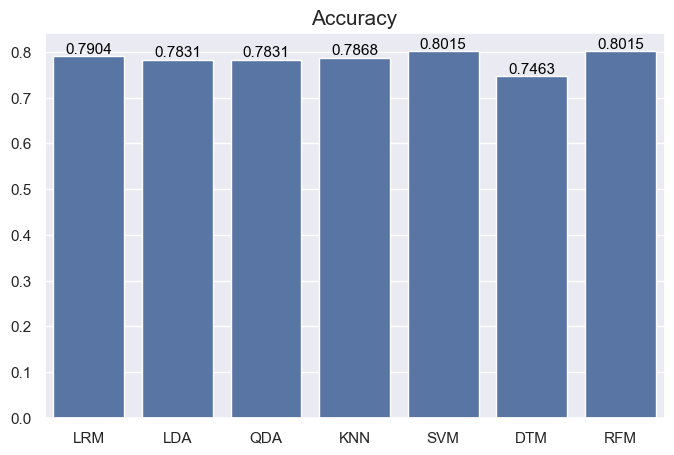

In [37]:
# accuracy
accuracy = [results_classif[c]['acc'] for c in results_classif.keys()]
sns.set(rc={"figure.figsize": (8, 5)})
ax = sns.barplot(x=list(results_classif.keys()), y=accuracy)

# Add labels to the top of each bar
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.4f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        fontsize=11,
        color='black',
        xytext=(0, 5),
        textcoords='offset points'
    )
plt.title('Accuracy', fontsize=15);

The `f1 score` is an essential metric in any classifier because it considers both precision and recall, providing a balanced evaluation of the classifier's performance.

By considering both precision and recall, the f1 score balances the two measures, which is helpful in scenarios where both false positives and false negatives have different consequences. For instance, a false negative (not detecting a disease) can be more severe in medical diagnosis systems than a false positive (detecting a disease when it is not present). In contrast, in spam email classification, a false positive (marking a legitimate email as spam) can be more severe than a false negative (marking a spam email as legitimate). 

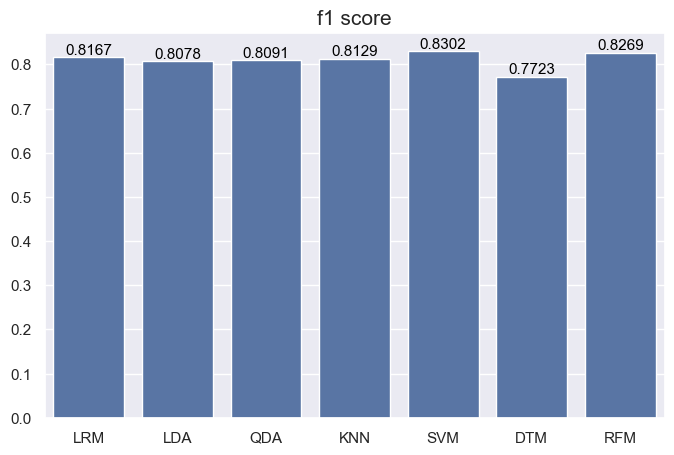

In [38]:
# f1 score
f1score = [results_classif[c]['f1'] for c in results_classif.keys()]
ax = sns.barplot(x=list(results_classif.keys()), y=f1score)

# Add labels to the top of each bar
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.4f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        fontsize=11,
        color='black',
        xytext=(0, 5),
        textcoords='offset points'
    )
plt.title('f1 score', fontsize=15);

The Receiver Operating Characteristic (`ROC`) curve is a graphical representation of the performance of a binary classification model. It is created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds.

The Area Under the Curve (`AUC`) of the ROC curve is a scalar value that measures the model's overall performance. The AUC ranges from 0.0 to 1.0, where a score of 0.5 indicates that the model is no better than random guessing, and a score of 1.0 means perfect performance. 

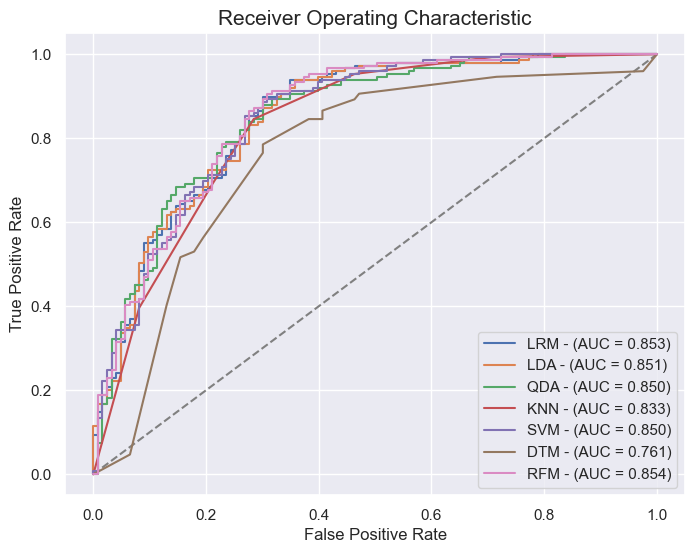

In [39]:
# Plot the ROC curves for each classifier
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
for c in results_classif.keys():
    plt.plot(
        results_classif[c]['fpr'],
        results_classif[c]['tpr'],
        label=f'{c} - (AUC = {results_classif[c]['auc']:.3f})'
    )
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', fontsize=15);

## Conclusions

Key Takeaways
- Multiple classifiers were trained and tested, including Logistic Regression, SVM, kNN, Decision Trees, and Random Forests.
- Feature importance revealed significant predictors contributing to heart disease.
- Performance metrics such as accuracy and F1 score varied across models, with ensemble methods like Random Forest performing better.
- The removal of outliers and feature scaling helped improve the model performances.

## References


- VanderPlas, J. (2017) Python Data Science Handbook: Essential Tools for Working with Data. USA: O’Reilly Media, Inc, chapter 5